In [1]:
# !gdown --id 1Z79gdspuXtAegoq-_eBbLwZT8-5RUA1f
# !gdown --id 1cNQqmd1p7gj6SBfCyU_myIkJ7g5jbEw9
# !gdown --id 1Smqw9wd1u6WJLO0wmWwKInzmcA2osw42

In [2]:
#!nvidia-smi

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
import pandas as pd
import re
import numpy as np
import itertools
import collections
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud

import nltk
nltk.download('treebank')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

import gensim
from gensim.models import KeyedVectors, Word2Vec, FastText

import tensorflow as tf
import unicodedata

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
C:\Users\phvpa\anaconda3\envs\NLP\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, b

In [5]:
#ls

In [6]:
train_df = pd.read_csv("kannada_sentiment_full_train.tsv", sep='\t')
print(len(train_df))

valid_df = pd.read_csv("kannada_sentiment_full_dev.tsv", sep='\t')
print(len(valid_df))

test_df = pd.read_csv("kannada_sentiment_full_test_withoutlabels.tsv", sep='\t')
len(test_df)

6212
691


768

In [7]:
test_df

,id,text
0,Kan_1,ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇ...
1,Kan_2,Jai D Boss
2,Kan_3,Signature move
3,Kan_4,Super song bro
4,Kan_5,Wow Super agi helidira sir
...,...,...
763,Kan_764,Thu thukali trailer
764,Kan_765,Siri gannadam galge haakbitallapa Thu yaro ni...
765,Kan_766,ನಾವೇನಾದರು ಸ್ವಾಬಿಮಾನಿಯಾಗಿ ಬದುಕನ್ನು ಕಟ್ಟಿಕೊಳ್ಳಲು...
766,Kan_767,ದಿಯಾ ನೀವು ಸೋಷಿಯಲ್ ಮೀಡಿಯಾ ಅಲ್ಲಿ ಕಾಣ್ತಿಲ್ಲ.nದಯವಿ...


In [8]:
print(test_df['text'][0])

ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇಷ್ಟವಾಗಿದೆ ಲೈಕ್ ಮಾಡಿಗಾಳಿ ಮಾತಿನ ಬಜಾರು ಸುದ್ದಿ ಸಾರಿದೆ..........@@@@


In [9]:
train_df['text'][6208]

'പൊളി ഡാൻസ്🥰 രക്ഷിത് ഷെട്ടി മാസ്സ്'

In [10]:
train_df

,text,category
0,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...,Negative
1,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...,Positive
2,Super sar song,not-Kannada
3,Tiktokers present situation... nನೋಡುವವರು ಯಾರು ...,Negative
4,Super ಸಾಂಗ್ ವೆರಿ ನೈಸ್....,Positive
...,...,...
6207,@A.R.W tumbad tanhaji andhadhun aise bahot h...,not-Kannada
6208,പൊളി ഡാൻസ്🥰 രക്ഷിത് ഷെട്ടി മാസ്സ്,not-Kannada
6209,Bro...nNeen este Roast madudru...China ne beku...,Negative
6210,ಕೌಶಲ್ಯ ಇದ್ದವರ ಸಂಖ್ಯೆ ಕಡಿಮೆ ಇಲ್ಲ ಸರ್ ತುಂಬಾ ಪ್ರತ...,Positive


In [11]:
valid_df

,text,category
0,Binduge saryagi ugithidira good go ahead we a...,Mixed feelings
1,yen song guru ...super,Positive
2,my fevorat story,not-Kannada
3,Super ತೋಗರಿ ತೀಪ್ಪ,Positive
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...,Positive
...,...,...
686,@Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative
687,Hugi guru badethawke,Negative
688,Trending no.1 wow,Positive
689,@Troll Stupid Fans naanu adikke kano helthirod...,Positive


In [12]:
valid_df['text']

0      Binduge saryagi ugithidira good go ahead  we a...
1                                 yen song guru ...super
2                                       my fevorat story
3                                      Super ತೋಗರಿ ತೀಪ್ಪ
4      ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...
                             ...                        
686    @Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ
687                                 Hugi guru badethawke
688                                    Trending no.1 wow
689    @Troll Stupid Fans naanu adikke kano helthirod...
690    @JustAn Opinion ninu Tika mucchu...Evattu Kann...
Name: text, Length: 691, dtype: object

In [13]:
#removing all the emoji from the given data

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


for i in range(len(train_df)):
    temp1 = deEmojify(train_df['text'][i])
    train_df['text'][i] = temp1

for j in range(len(valid_df)):
    temp2 = deEmojify(valid_df['text'][j])
    valid_df['text'][j] = temp2

for k in range(len(test_df)):
    temp3 = deEmojify(test_df['text'][k])
    test_df['text'][k]=temp3

In [14]:
print(train_df['text'][6208])

പൊളി ഡാൻസ് രക്ഷിത് ഷെട്ടി മാസ്സ്


In [15]:
def preprocess_data(text):
  user_name = '@[A-Za-z0-9]+' # Pattern for matching the user names in the tweet
  has_tag = '#[A-Za-z0-9]+' # Pattern for matching the hasgtags in the tweer
  url = 'https?:\/\/[A-Za-z0-9\.\/\-]+' # Pattern for matching the URLs in the tweet
  #emoji_pattern = r'/[x{1F600}-x{1F64F}]/u'
  
  x = text.lower()  # Lower casing all the characters
  x = re.sub(user_name, '', x) # Replace the username with an empty characrer
  x = re.sub(has_tag,'',x) # Replace the hashtags with an empty characrer
  x = re.sub(url, '', x) # Replace the URLs with an empty characrer
  #x = re.sub(emoji_pattern, '', x)
  x = x.translate(str.maketrans('', '', string.punctuation)) # Replace all the characters except alphabets and digits from the tweet

  return x

In [16]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
valid_df['text'] = valid_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
test_df['text'] = test_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe

In [17]:
valid_df['text'][0]

'binduge saryagi ugithidira good go ahead  we are enjoying well'

In [18]:
print(train_df)
print()
#print(valid_df.head())
#print()
print(valid_df)
print()
print(test_df)

                                                   text        category
0     ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...        Negative
1     ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...        Positive
2                                        super sar song     not-Kannada
3     tiktokers present situation nನೋಡುವವರು ಯಾರು ನಮ್...        Negative
4                                 super ಸಾಂಗ್ ವೆರಿ ನೈಸ್        Positive
...                                                 ...             ...
6207  rw   tumbad tanhaji andhadhun aise bahot hai p...     not-Kannada
6208                   പൊളി ഡാൻസ് രക്ഷിത് ഷെട്ടി മാസ്സ്     not-Kannada
6209  bronneen este roast madudruchina ne beku antha...        Negative
6210  ಕೌಶಲ್ಯ ಇದ್ದವರ ಸಂಖ್ಯೆ ಕಡಿಮೆ ಇಲ್ಲ ಸರ್ ತುಂಬಾ ಪ್ರತ...        Positive
6211                                         26 m views  Mixed feelings

[6212 rows x 2 columns]

                                                  text        category
0    binduge saryagi ugithidira good go

In [19]:
train_text = train_df['text'].tolist()
valid_text = valid_df['text'].tolist()
test_text = test_df['text'].tolist()

train_label = train_df['category'].tolist()
valid_label = valid_df['category'].tolist()


In [20]:
test_text

['ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇಷ್ಟವಾಗಿದೆ ಲೈಕ್ ಮಾಡಿಗಾಳಿ ಮಾತಿನ ಬಜಾರು ಸುದ್ದಿ ಸಾರಿದೆ',
 'jai d boss',
 'signature move',
 'super song bro',
 'wow  super agi helidira sir',
 'waiting  asn',
 'film nodidmele ee song ge addict aadavaru like maadinyalllrigu thanks for 1000 likes',
 'i like it',
 'avanige gaya vasi agbeku andreavnu krishna na bhakti madivasi madbeku eela kaliyuga nasa agbeku',
 'ಚಂದನ್ ಶೆಟ್ಟಿ ಟ್ರೊಲ್ ವಿಡಿಯೋ ನೀವು ನೋಡಿ ನೆಗಡ್ಡೆ ಇದ್ರೆ ನಾವ್ ಗ್ಯಾರಂಟಿ',
 'ಮೊದಲು ನಿನ್ನ ಗುಲಾಮು ಜಾಮ್ ಬಿದ್ದಿದ್ದ ನೋಡು',
 'sir nanu china apps na delete ಮಾಡಿದೀನಿ sir',
 'super songs super steps',
 ' kudla kannadadalli nodi kannada version views jaasti maadi',
 'supper bro chenngi ugdidira',
 'ನಾನು ಸುಮಾರು ಈ ಹಾಡನ್ನು ಹದಿನೈದು ಬಾರಿ ನೋಡಿದ್ದೇನೆ ಯಾಕೆ ಗೊತ್ತಿಲ್ಲ ಇನ್ನು ನೋಡಬೇಕು ನೋಡಬೇಕು ಅನಿಸುತ್ತದೆ ಅದೇತರ ಒಂದಕ್ಕಿಂತ ಹೆಚ್ಚು ಬಾರಿ ನೋಡುತ್ತಲೇ ಇರುವವರು ಲೈಕ್ ಮಾಡಿ',
 'nimmamman hogi alli kelsa madu gothagute',
 'idu charitrae srushtiso cinemannae',
 'yakappa yenaytu movie swalpa length jasti adre movie chennagide',
 'enn 

In [21]:
class_names = list(set(train_label))
class_names

['Mixed feelings', 'Negative', 'not-Kannada', 'Positive', 'unknown state']

In [22]:
class_dist = Counter(train_label)
class_dist

Counter({'Negative': 1188,
         'Positive': 2823,
         'not-Kannada': 916,
         'Mixed feelings': 574,
         'unknown state': 711})

In [23]:
le = LabelEncoder()

train_label = le.fit_transform(train_label)
train_label

array([1, 2, 3, ..., 1, 2, 0], dtype=int64)

In [24]:
valid_label = le.fit_transform(valid_label)
valid_label

array([0, 2, 3, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 1, 3, 1, 2, 2, 2, 0, 2, 2,
       1, 1, 3, 0, 1, 2, 0, 4, 2, 2, 2, 1, 3, 1, 2, 2, 1, 4, 1, 1, 2, 4,
       2, 1, 1, 2, 2, 4, 1, 2, 4, 2, 2, 2, 2, 2, 2, 3, 3, 1, 3, 2, 1, 2,
       2, 1, 0, 2, 3, 4, 2, 4, 3, 1, 2, 2, 3, 2, 3, 3, 3, 0, 2, 4, 2, 0,
       2, 3, 2, 2, 3, 2, 2, 2, 2, 0, 2, 4, 2, 3, 4, 2, 3, 1, 2, 3, 4, 1,
       2, 1, 3, 2, 1, 2, 0, 2, 2, 3, 0, 1, 2, 1, 2, 4, 2, 2, 2, 3, 2, 2,
       2, 1, 2, 4, 0, 2, 4, 4, 4, 2, 1, 2, 2, 3, 4, 1, 3, 2, 1, 2, 0, 2,
       1, 2, 1, 2, 2, 2, 2, 3, 2, 4, 2, 1, 2, 1, 2, 3, 1, 2, 2, 1, 2, 4,
       1, 0, 3, 4, 2, 1, 2, 0, 3, 2, 1, 1, 2, 2, 1, 4, 4, 4, 2, 1, 3, 2,
       2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 3, 2, 1, 4, 2, 1, 2, 0, 2,
       2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 4, 1, 2, 1,
       1, 3, 2, 1, 2, 1, 2, 2, 2, 3, 1, 2, 3, 2, 2, 2, 2, 1, 3, 3, 2, 2,
       2, 3, 2, 2, 2, 1, 2, 4, 0, 3, 4, 1, 2, 2, 1, 2, 2, 1, 3, 2, 1, 2,
       4, 2, 1, 2, 2, 3, 3, 2, 3, 3, 4, 2, 2, 4, 2,

In [25]:
le.inverse_transform([0,1,2,3,4])

array(['Mixed feelings', 'Negative', 'Positive', 'not-Kannada',
       'unknown state'], dtype='<U14')

In [26]:
class_weight = {0:sum(class_dist.values())/class_dist[le.inverse_transform([0])[0]],
                1:sum(class_dist.values())/class_dist[le.inverse_transform([1])[0]],
                2:sum(class_dist.values())/class_dist[le.inverse_transform([2])[0]],
                3:sum(class_dist.values())/class_dist[le.inverse_transform([3])[0]],
                4:sum(class_dist.values())/class_dist[le.inverse_transform([4])[0]]}

class_weight

{0: 10.822299651567944,
 1: 5.228956228956229,
 2: 2.200495926319518,
 3: 6.781659388646288,
 4: 8.736990154711673}

In [27]:
training_labels = tf.keras.utils.to_categorical(train_label)
validation_labels = tf.keras.utils.to_categorical(valid_label)

In [28]:
words_in_train = [sent.split() for sent in train_text] # Splitting the tweet into tokens
words_in_train[0:5]

[['ಒಂದು',
  'ದೇಶದ',
  'ಮುಂದುವರಿಯುವುದು',
  'ಅದರ',
  'ಆರ್ಥಿಕ',
  'ಸ್ಥಿತಿಯನ್ನು',
  'ಅವಲಂಬಿಸುವುದಿಲ್ಲ',
  'ಅವರು',
  'ಮಾನವೀಯತೆಯಲ್ಲಿ',
  'ಎಷ್ಟು',
  'ಸಮರ್ಥರು',
  'ಎನ್ನುವುದನ್ನು',
  'ಅವಲಂಬಿಸಿದೆ',
  'ಭಾರತದಲ್ಲಿ',
  'ಅನಕ್ಷರತೆ',
  'ಇದೆ',
  'ಆ',
  'ಅನಕ್ಷರಸ್ಥರನ್ನು',
  'ಅವರ',
  'ಅನಕ್ಷರತೆಯೇ'],
 ['ಕನ್ನಡದಲ್ಲಿ',
  'ಡೈಲಿ',
  'ಟೆಕ್',
  'ಅಪ್ಡೇಟ್ಸ್',
  'ಪಡೆಯಲು',
  'ಸಬ್ಸ್ಕ್ರೈಬ್',
  'ಮಾಡಿ',
  'ನಮ್ಮ',
  'ಚನ್ನೆಲ್ಗೆ'],
 ['super', 'sar', 'song'],
 ['tiktokers',
  'present',
  'situation',
  'nನೋಡುವವರು',
  'ಯಾರು',
  'ನಮ್ಮ',
  'ವೀಡಿಯೋನೂ'],
 ['super', 'ಸಾಂಗ್', 'ವೆರಿ', 'ನೈಸ್']]

In [29]:
words_in_valid = [sent.split() for sent in valid_text] # Splitting the tweet into tokens
words_in_valid[0:5]

[['binduge',
  'saryagi',
  'ugithidira',
  'good',
  'go',
  'ahead',
  'we',
  'are',
  'enjoying',
  'well'],
 ['yen', 'song', 'guru', 'super'],
 ['my', 'fevorat', 'story'],
 ['super', 'ತೋಗರಿ', 'ತೀಪ್ಪ'],
 ['ನಿಮ್ಮ',
  'ಮಾತುಗಳು',
  'ಅಕ್ಷರಶಃ',
  'ಸತ್ಯ',
  'ನಿಮ್ಮ',
  'ಈ',
  'ಸಾಮಾನ್ಯ',
  'ಜೀವನ',
  'ನೋಡಿ',
  'ಕುಷಿ',
  'ಆಯಿತು']]

In [30]:
words_in_test = [sent.split() for sent in test_text] # Splitting the tweet into tokens
words_in_test[0:5]

[['ಈ',
  'ಹಾಡನ್ನು',
  'ಹಾಡಿದ',
  'ವಿಜಯ',
  'ಪ್ರಕಾಶ',
  'voice',
  'ಯಾರಿಗೆಲ್ಲಾ',
  'ಇಷ್ಟವಾಗಿದೆ',
  'ಲೈಕ್',
  'ಮಾಡಿಗಾಳಿ',
  'ಮಾತಿನ',
  'ಬಜಾರು',
  'ಸುದ್ದಿ',
  'ಸಾರಿದೆ'],
 ['jai', 'd', 'boss'],
 ['signature', 'move'],
 ['super', 'song', 'bro'],
 ['wow', 'super', 'agi', 'helidira', 'sir']]

In [31]:
#words_in_test = [sent.split() for sent in test_text] # Splitting the tweet into tokens
#words_in_test[0:5]

In [32]:
all_words_train = list(itertools.chain(*words_in_train)) # Making a flatlist of all the words in the corpus
all_words_train[0:10]

['ಒಂದು',
 'ದೇಶದ',
 'ಮುಂದುವರಿಯುವುದು',
 'ಅದರ',
 'ಆರ್ಥಿಕ',
 'ಸ್ಥಿತಿಯನ್ನು',
 'ಅವಲಂಬಿಸುವುದಿಲ್ಲ',
 'ಅವರು',
 'ಮಾನವೀಯತೆಯಲ್ಲಿ',
 'ಎಷ್ಟು']

In [33]:
all_words_valid = list(itertools.chain(*words_in_valid)) # Making a flatlist of all the words in the corpus
all_words_valid[0:10]

['binduge',
 'saryagi',
 'ugithidira',
 'good',
 'go',
 'ahead',
 'we',
 'are',
 'enjoying',
 'well']

In [34]:
all_words_test = list(itertools.chain(*words_in_test)) # Making a flatlist of all the words in the corpus
all_words_test[0:10]

['ಈ',
 'ಹಾಡನ್ನು',
 'ಹಾಡಿದ',
 'ವಿಜಯ',
 'ಪ್ರಕಾಶ',
 'voice',
 'ಯಾರಿಗೆಲ್ಲಾ',
 'ಇಷ್ಟವಾಗಿದೆ',
 'ಲೈಕ್',
 'ಮಾಡಿಗಾಳಿ']

In [35]:
word_counts_train = collections.Counter(all_words_train)  # Computing the number of occurrence of all the words in the corpus
word_counts_train.most_common(15)

[('super', 919),
 ('song', 474),
 ('bro', 434),
 ('sir', 415),
 ('movie', 367),
 ('guru', 332),
 ('like', 260),
 ('boss', 200),
 ('kannada', 197),
 ('i', 176),
 ('madi', 173),
 ('ge', 169),
 ('ಈ', 160),
 ('ಸೂಪರ್', 152),
 ('anna', 148)]

In [36]:
word_counts_valid = collections.Counter(all_words_valid)  # Computing the number of occurrence of all the words in the corpus
word_counts_valid.most_common(15)

[('super', 106),
 ('song', 62),
 ('sir', 50),
 ('bro', 48),
 ('movie', 39),
 ('guru', 37),
 ('like', 32),
 ('madi', 21),
 ('ಈ', 20),
 ('fans', 20),
 ('kannada', 19),
 ('nim', 19),
 ('e', 19),
 ('ge', 18),
 ('all', 15)]

In [37]:
word_counts_test = collections.Counter(all_words_test)  # Computing the number of occurrence of all the words in the corpus
word_counts_test.most_common(15)

[('super', 137),
 ('song', 66),
 ('sir', 57),
 ('bro', 55),
 ('movie', 46),
 ('guru', 44),
 ('ಈ', 34),
 ('like', 28),
 ('kannada', 27),
 ('madi', 25),
 ('boss', 24),
 ('ಸೂಪರ್', 24),
 ('ge', 23),
 ('film', 22),
 ('i', 22)]

In [38]:
# Creating a dataframe with words and corresponding frequency
words_with_counts_train = pd.DataFrame(word_counts_train.most_common(len(all_words_train)), columns=['words', 'count']) 
print(words_with_counts_train.head())

   words  count
0  super    919
1   song    474
2    bro    434
3    sir    415
4  movie    367


In [39]:
# Creating a dataframe with words and corresponding frequency
words_with_counts_valid = pd.DataFrame(word_counts_valid.most_common(len(all_words_valid)), columns=['words', 'count']) 
print(words_with_counts_valid.head())

   words  count
0  super    106
1   song     62
2    sir     50
3    bro     48
4  movie     39


In [40]:
# Creating a dataframe with words and corresponding frequency
words_with_counts_test = pd.DataFrame(word_counts_test.most_common(len(all_words_test)), columns=['words', 'count']) 
print(words_with_counts_test.head())

   words  count
0  super    137
1   song     66
2    sir     57
3    bro     55
4  movie     46


In [41]:
all_words = all_words_train + all_words_valid + all_words_test
corpus = train_text + valid_text + test_text
vocab_size = len(set(all_words)) # number of words to keep.
embedding_dim = 100 # Dimension of the vector representation for each word 
max_length = 0
for i in range(len(corpus)):
  x = word_tokenize(corpus[i])
  if len(x) > max_length:
    max_length = len(x)

oov_tok = "<OOV>"  # Token to represent Out-of-Vocabulary words

In [42]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

In [43]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(train_text)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences,maxlen=max_length, padding='post')

valid_sequences = tokenizer.texts_to_sequences(valid_text)
valid_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_sequences,maxlen=max_length, padding='post')


test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen=max_length, padding='post')

In [44]:
METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [45]:
print(np.shape(training_padded))
print(np.shape(valid_padded))
print(np.shape(test_padded))

(6212, 96)
(691, 96)
(768, 96)


In [46]:
filter_size = 128
kernel_size = 5
pool_size = 5

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length,
                              embeddings_initializer='orthogonal', embeddings_regularizer='L2'),
    tf.keras.layers.Conv1D(filter_size, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size, padding='same'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=METRICS
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 96, 100)           1839900   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 1,947,489
Trainable params: 1,947,489
Non-trainable params: 0
______________________________________________

In [47]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)

num_epochs = 100
history = model.fit(
    training_padded,
    training_labels,
    epochs=num_epochs,
    batch_size = 128,
    callbacks=[callback],
    validation_data=(valid_padded, validation_labels),
    class_weight=class_weight
)

Epoch 1/100
49/49 [==============================] - 26s 71ms/step - loss: 8.2191 - accuracy: 0.8047 - precision: 0.4389 - recall: 0.0754 - auc: 0.6589 - val_loss: 3.6183 - val_accuracy: 0.8284 - val_precision: 0.7663 - val_recall: 0.2041 - val_auc: 0.7761
Epoch 2/100
49/49 [==============================] - 1s 19ms/step - loss: 8.4416 - accuracy: 0.8310 - precision: 0.6801 - recall: 0.2957 - auc: 0.7994 - val_loss: 3.7650 - val_accuracy: 0.8397 - val_precision: 0.7147 - val_recall: 0.3300 - val_auc: 0.8411
Epoch 3/100
49/49 [==============================] - 1s 19ms/step - loss: 8.4334 - accuracy: 0.8449 - precision: 0.7101 - recall: 0.3796 - auc: 0.8314 - val_loss: 4.4836 - val_accuracy: 0.8307 - val_precision: 0.6803 - val_recall: 0.2894 - val_auc: 0.7918
Epoch 4/100
49/49 [==============================] - 1s 19ms/step - loss: 8.5939 - accuracy: 0.8430 - precision: 0.6979 - recall: 0.3801 - auc: 0.8412 - val_loss: 4.8282 - val_accuracy: 0.8420 - val_precision: 0.6986 - val_recall: 

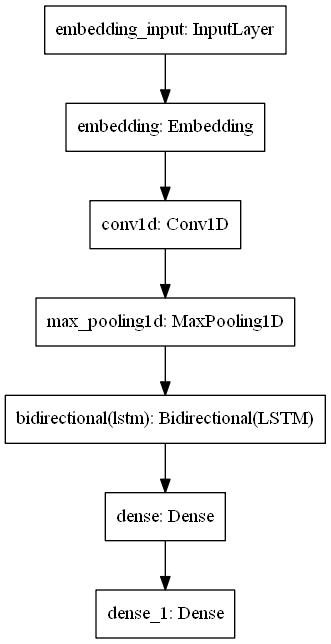

In [48]:
tf.keras.utils.plot_model(
    model,
    to_file="CNN+BILSTM.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

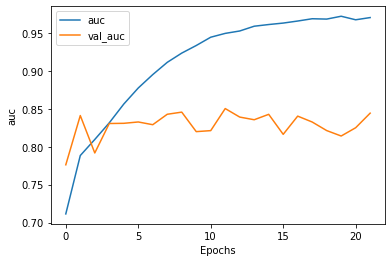

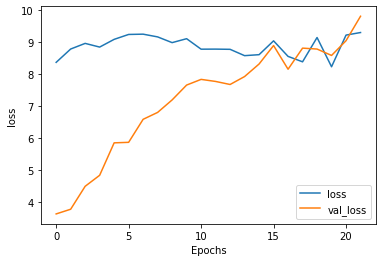

In [49]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc")
plot_graphs(history, "loss")

In [50]:
score = model.evaluate(valid_padded, validation_labels)
print("Loss = {}".format(score[0]))
print("Accuracy = {0:.2f}%".format(score[1]*100))
print(score)

22/22 [==============================] - 1s 15ms/step - loss: 7.7683 - accuracy: 0.8411 - precision: 0.6228 - recall: 0.5210 - auc: 0.8503
Loss = 7.768267631530762
Accuracy = 84.11%
[7.768267631530762, 0.8410999774932861, 0.6228373646736145, 0.5209840536117554, 0.8503472805023193]


In [51]:
y_pred = model.predict_classes(valid_padded)

accuracy = accuracy_score(valid_label, y_pred)
precision = precision_score(valid_label, y_pred, average='macro')
recall = recall_score(valid_label, y_pred, average='macro')
f1 = f1_score(valid_label, y_pred, average='macro')

print("Accuracy = {0:.2f}".format(accuracy*100))
print("Precision = {0:.4f}".format(precision))
print("Recall = {0:.4f}".format(recall))
print("F1-score = {0:.4f}".format(f1))

C:\Users\phvpa\anaconda3\envs\NLP\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy = 58.47
Precision = 0.5007
Recall = 0.5248
F1-score = 0.5085


In [52]:
confusion_matrix(valid_label,y_pred)

array([[ 13,  11,  19,   4,   5],
       [ 15,  87,  27,   4,   6],
       [ 26,  38, 198,  48,  11],
       [  2,   5,  11,  75,  17],
       [  9,   4,  10,  15,  31]], dtype=int64)

In [53]:
print(classification_report(valid_label,y_pred))

              precision    recall  f1-score   support

           0       0.20      0.25      0.22        52
           1       0.60      0.63      0.61       139
           2       0.75      0.62      0.68       321
           3       0.51      0.68      0.59       110
           4       0.44      0.45      0.45        69

    accuracy                           0.58       691
   macro avg       0.50      0.52      0.51       691
weighted avg       0.61      0.58      0.59       691



In [54]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews           

def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = tf.keras.preprocessing.sequence.pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  classes = model.predict_classes(reviews_padded)
  classes_prob = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(le.inverse_transform([classes[x]]))
    print(classes_prob[x])
    print('\n')


In [55]:
sample_test = test_text[0:10]
sample_test

['ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇಷ್ಟವಾಗಿದೆ ಲೈಕ್ ಮಾಡಿಗಾಳಿ ಮಾತಿನ ಬಜಾರು ಸುದ್ದಿ ಸಾರಿದೆ',
 'jai d boss',
 'signature move',
 'super song bro',
 'wow  super agi helidira sir',
 'waiting  asn',
 'film nodidmele ee song ge addict aadavaru like maadinyalllrigu thanks for 1000 likes',
 'i like it',
 'avanige gaya vasi agbeku andreavnu krishna na bhakti madivasi madbeku eela kaliyuga nasa agbeku',
 'ಚಂದನ್ ಶೆಟ್ಟಿ ಟ್ರೊಲ್ ವಿಡಿಯೋ ನೀವು ನೋಡಿ ನೆಗಡ್ಡೆ ಇದ್ರೆ ನಾವ್ ಗ್ಯಾರಂಟಿ']

In [56]:
predict_review(model, sample_test)

C:\Users\phvpa\anaconda3\envs\NLP\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇಷ್ಟವಾಗಿದೆ ಲೈಕ್ ಮಾಡಿಗಾಳಿ ಮಾತಿನ ಬಜಾರು ಸುದ್ದಿ ಸಾರಿದೆ
['Positive']
[0.0886775  0.00467732 0.8348756  0.02115365 0.05061603]


jai d boss
['not-Kannada']
[0.06956279 0.00879061 0.10454042 0.512731   0.30437517]


signature move
['unknown state']
[0.03613936 0.00272555 0.02093443 0.12647295 0.8137277 ]


super song bro
['not-Kannada']
[1.11519014e-02 8.32408725e-04 1.01549774e-01 8.62175107e-01
 2.42908802e-02]


wow  super agi helidira sir
['Positive']
[0.03640031 0.01053178 0.6194187  0.27863407 0.05501514]


waiting  asn
['not-Kannada']
[0.03117261 0.00448043 0.3618979  0.5454935  0.05695559]


film nodidmele ee song ge addict aadavaru like maadinyalllrigu thanks for 1000 likes
['Mixed feelings']
[0.3573919  0.18061808 0.33193585 0.02925225 0.10080195]


i like it
['not-Kannada']
[0.01154652 0.0009261  0.06256279 0.8589793  0.06598528]


avanige gaya vasi agbeku andreavnu krishna na bhakti madivasi madbeku eela kaliyuga nasa agbeku
['Positive'

In [57]:
classes = model.predict_classes(test_padded)
pred = []

for i in range(len(classes)):
  pred.append(le.inverse_transform([classes[i]])[0])

In [58]:
#pred[:]

In [59]:
pred_df = pd.DataFrame(pred, columns=['label'])
pred_df.head()

,label
0,Positive
1,not-Kannada
2,unknown state
3,not-Kannada
4,Positive


In [60]:
result = pd.concat([test_df, pred_df], axis=1)
result.head()

,id,text,label
0,Kan_1,ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇ...,Positive
1,Kan_2,jai d boss,not-Kannada
2,Kan_3,signature move,unknown state
3,Kan_4,super song bro,not-Kannada
4,Kan_5,wow super agi helidira sir,Positive


In [61]:
result.to_csv('CNN+BiLSTM_Kannada_Test_Pred_Labels_22-06-2021.csv', sep = ',', index=False)

In [62]:
Valid_classes = model.predict_classes(valid_padded)
Valid_pred = []

for i in range(len(Valid_classes)):
    Valid_pred.append(le.inverse_transform([Valid_classes[i]])[0])

C:\Users\phvpa\anaconda3\envs\NLP\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [63]:
Valid_classes.shape

(691,)

In [64]:
Valid_pred_df = pd.DataFrame(Valid_pred, columns=['Predicted label'])
Valid_pred_df.head()

,Predicted label
0,Mixed feelings
1,Positive
2,unknown state
3,not-Kannada
4,Positive


In [65]:
Valid_result = pd.concat([valid_df, Valid_pred_df], axis=1)
Valid_result

,text,category,Predicted label
0,binduge saryagi ugithidira good go ahead we a...,Mixed feelings,Mixed feelings
1,yen song guru super,Positive,Positive
2,my fevorat story,not-Kannada,unknown state
3,super ತೋಗರಿ ತೀಪ್ಪ,Positive,not-Kannada
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ಜೀವ...,Positive,Positive
...,...,...,...
686,parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative,Negative
687,hugi guru badethawke,Negative,Positive
688,trending no1 wow,Positive,not-Kannada
689,stupid fans naanu adikke kano helthirodu nin...,Positive,Negative


In [66]:
Valid_result.to_csv('CNN+BiLSTM_Kannada_Valid_Pred_Labels_22-06-2021.csv', sep = ',', index=False)

In [67]:
valid_df

,text,category
0,binduge saryagi ugithidira good go ahead we a...,Mixed feelings
1,yen song guru super,Positive
2,my fevorat story,not-Kannada
3,super ತೋಗರಿ ತೀಪ್ಪ,Positive
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ಜೀವ...,Positive
...,...,...
686,parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative
687,hugi guru badethawke,Negative
688,trending no1 wow,Positive
689,stupid fans naanu adikke kano helthirodu nin...,Positive


In [68]:
d = pd.read_csv("CNN+BiLSTM_Kannada_Valid_Pred_Labels_22-06-2021.csv", sep=',')
d

,text,category,Predicted label
0,binduge saryagi ugithidira good go ahead we a...,Mixed feelings,Mixed feelings
1,yen song guru super,Positive,Positive
2,my fevorat story,not-Kannada,unknown state
3,super ತೋಗರಿ ತೀಪ್ಪ,Positive,not-Kannada
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ಜೀವ...,Positive,Positive
...,...,...,...
686,parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative,Negative
687,hugi guru badethawke,Negative,Positive
688,trending no1 wow,Positive,not-Kannada
689,stupid fans naanu adikke kano helthirodu nin...,Positive,Negative


In [69]:
d1 = pd.read_csv("CNN+BiLSTM_Kannada_Test_Pred_Labels_22-06-2021.csv", sep=',')
d1

,id,text,label
0,Kan_1,ಈ ಹಾಡನ್ನು ಹಾಡಿದ ವಿಜಯ ಪ್ರಕಾಶ voice ಯಾರಿಗೆಲ್ಲಾ ಇ...,Positive
1,Kan_2,jai d boss,not-Kannada
2,Kan_3,signature move,unknown state
3,Kan_4,super song bro,not-Kannada
4,Kan_5,wow super agi helidira sir,Positive
...,...,...,...
763,Kan_764,thu thukali trailer,unknown state
764,Kan_765,siri gannadam galge haakbitallapa thu yaro ni...,Negative
765,Kan_766,ನಾವೇನಾದರು ಸ್ವಾಬಿಮಾನಿಯಾಗಿ ಬದುಕನ್ನು ಕಟ್ಟಿಕೊಳ್ಳಲು...,Positive
766,Kan_767,ದಿಯಾ ನೀವು ಸೋಷಿಯಲ್ ಮೀಡಿಯಾ ಅಲ್ಲಿ ಕಾಣ್ತಿಲ್ಲnದಯವಿಟ...,Mixed feelings
